In [8]:
!pip install --upgrade tables
!pip install eli5

     |████████████████████████████████| 4.3MB 2.8MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 2.9MB/s 


In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

## Wczytywanie danych

In [11]:
df = pd.read_hdf('data/car.h5')
df.shape

(106494, 155)

In [12]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

##Dummy model

In [13]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [15]:
feats = ['car_id'] 
X = df[feats].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [16]:
[x for x in df.columns if 'price' in x] 

['price_currency', 'price_details', 'price_value']

In [20]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [19]:
df['price_currency'].value_counts(normalize=True) * 100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [21]:
df = df[ df['price_currency'] != 'EUR']
df.shape

(106290, 155)

##Features

In [25]:
df['param_color'].factorize()[0]

array([-1, -1, -1, ..., -1, -1, -1])

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue

  facorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = facorized_values
  else:
    df[feat + SUFFIX_CAT] = facorized_values

In [0]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x ]

In [0]:
cat_feats = [x for x in cat_feats if 'price' not in x ]

In [33]:
len(cat_feats)

151

In [34]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scorses = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scorses)

-19650.45289201444

In [37]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.1956 ± 0.0054,param_faktura-vat__cat
0.1903 ± 0.0027,param_napęd__cat
0.1815 ± 0.0087,param_stan__cat
0.1512 ± 0.0078,param_rok-produkcji__cat
0.0928 ± 0.0019,param_skrzynia-biegów__cat
0.0607 ± 0.0051,param_moc__cat
0.0436 ± 0.0015,feature_kamera-cofania__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0162 ± 0.0004,feature_bluetooth__cat
0.0110 ± 0.0007,feature_łopatki-zmiany-biegów__cat


In [41]:
imp_feats = ['param_faktura-vat', 'param_napęd', 'param_stan', 'param_rok-produkcji', 'param_skrzynia-biegów', 'param_moc', 'feature_kamera-cofania']
for feat in imp_feats:
  print()
  print('<------------------->')
  print(feat)
  print(df[feat].value_counts())


<------------------->
param_faktura-vat
Tak    26346
Name: param_faktura-vat, dtype: int64

<------------------->
param_napęd
Na przednie koła                 65926
Na tylne koła                     8589
4x4 (stały)                       6945
4x4 (dołączany automatycznie)     6859
4x4 (dołączany ręcznie)           1628
Name: param_napęd, dtype: int64

<------------------->
param_stan
Używane    96722
Nowe        9459
Name: param_stan, dtype: int64

<------------------->
param_rok-produkcji
2017    11737
2007     7484
2008     7298
2006     6935
2009     6236
        ...  
1958        1
1932        1
1944        1
1936        1
1933        1
Name: param_rok-produkcji, Length: 76, dtype: int64

<------------------->
param_skrzynia-biegów
Manualna                                 73314
Automatyczna hydrauliczna (klasyczna)    18464
Automatyczna dwusprzęgłowa (DCT, DSG)     6291
Automatyczna bezstopniowa (CVT)           1538
Półautomatyczna (ASG, Tiptronic)           891
Name: param_skrzyn

In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean,np.median, np.size], feat_sort='mean', top=50, subplots=True):
  return (
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by=feat_sort, ascending=False)
    .head(top)
).plot(kind='bar', figsize=(15, 5), subplots=subplots)

<------------------->
param_faktura-vat
<------------------->
param_napęd
<------------------->
param_stan
<------------------->
param_rok-produkcji
<------------------->
param_skrzynia-biegów
<------------------->
param_moc
<------------------->
feature_kamera-cofania


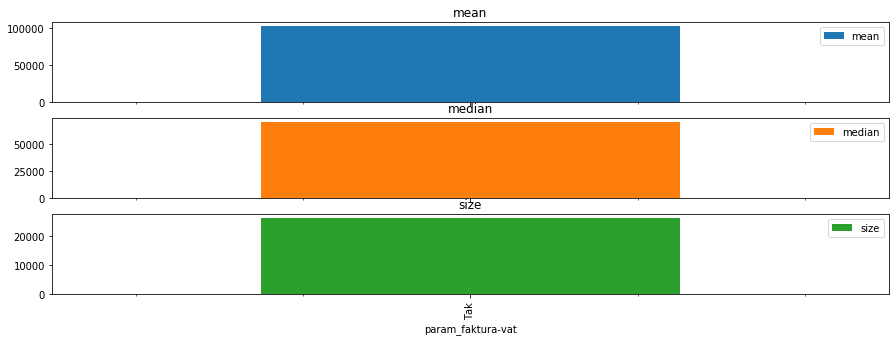

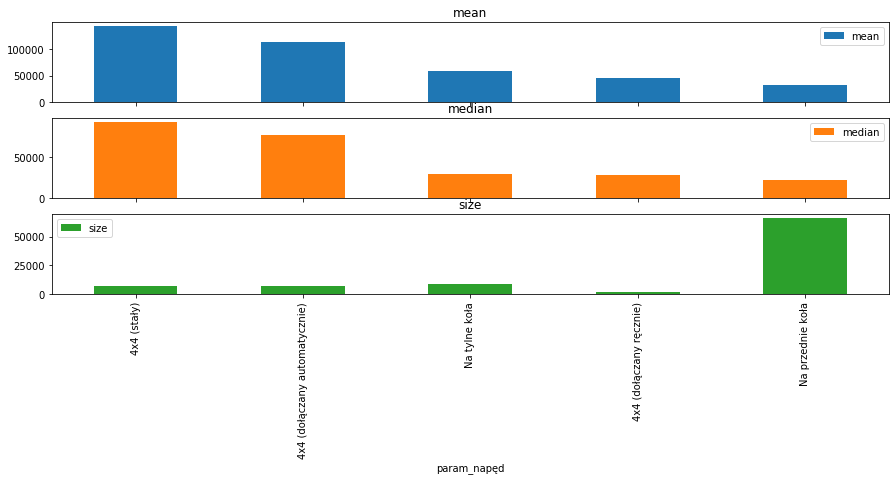

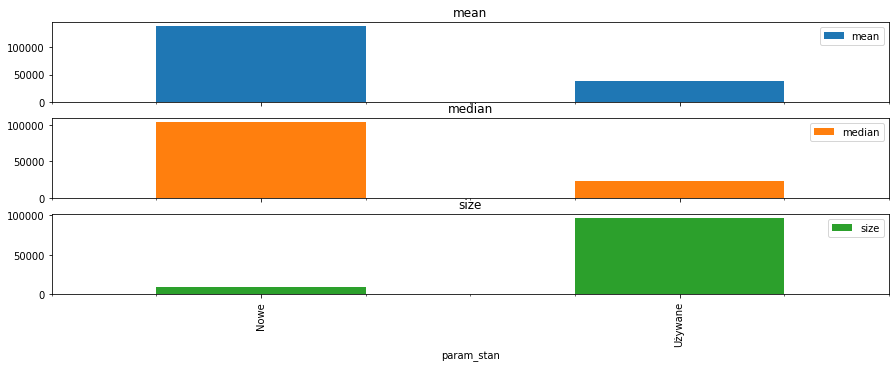

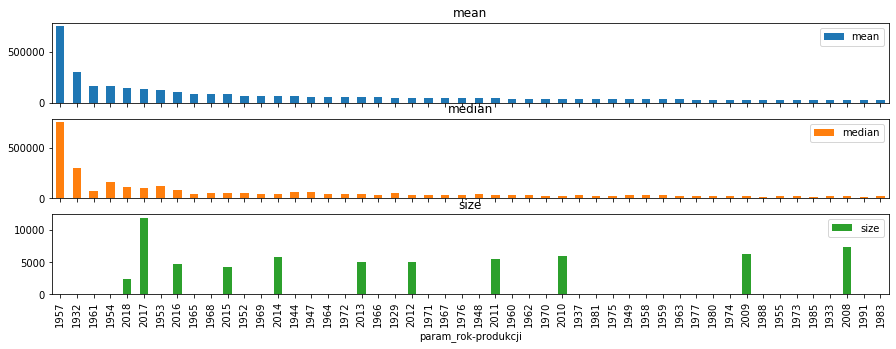

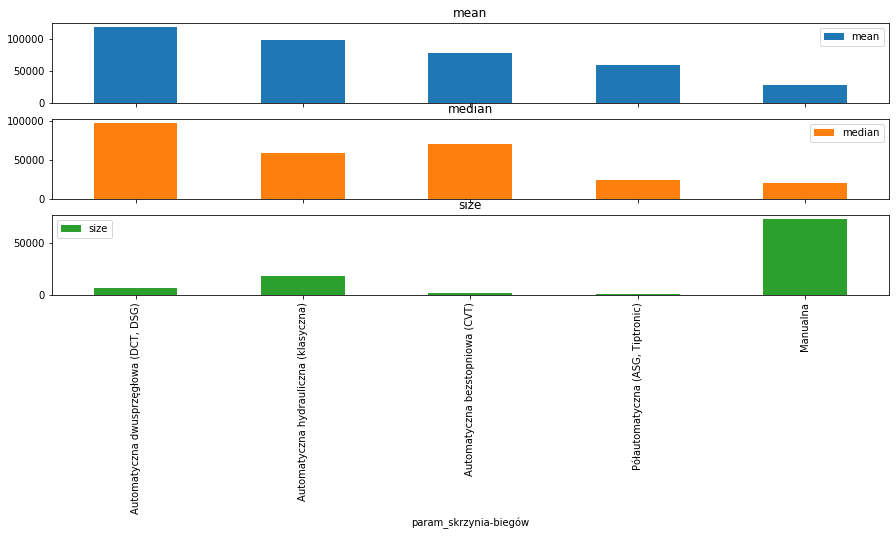

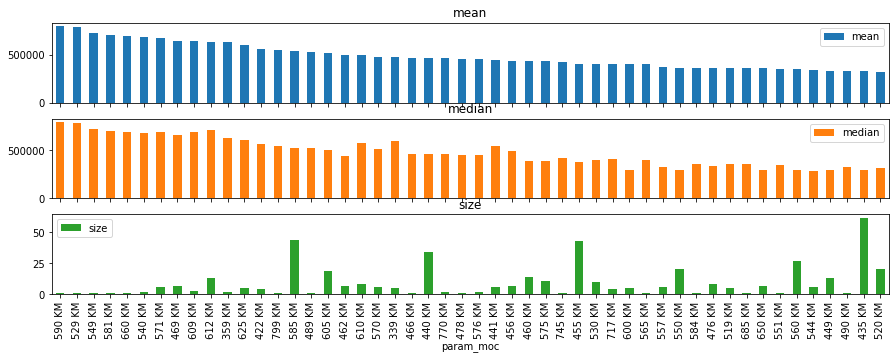

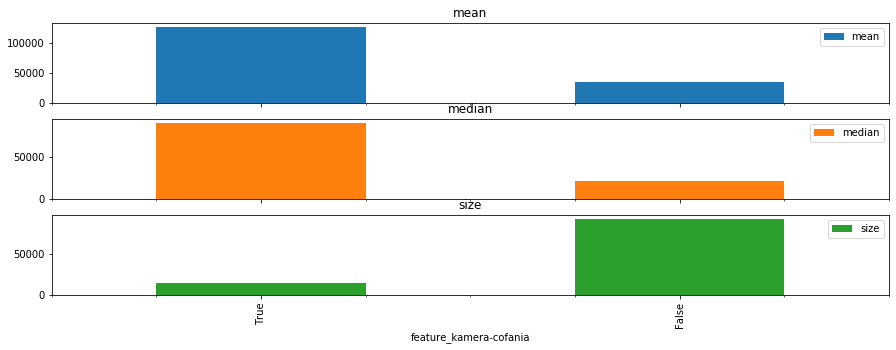

In [43]:
for feat in imp_feats:
  print('<------------------->')
  print(feat)
  group_and_barplot(feat);